<a href="https://colab.research.google.com/github/PascalLiPooKim/Football-prediction-model-project/blob/data-wrangling/footballPredictionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import missingno as msn

# Team Info

In [12]:
team_info_df = pd.read_csv('https://raw.githubusercontent.com/PascalLiPooKim/Football-prediction-model-project/data-wrangling/Football_Data/Football_Data/Team_Info.csv')
team_info_df.head()

,Team,City,Country,Stadium,Capacity,Pitch
0,Wattenscheid 09,Bochum-Wattenscheid,Germany,Lohrheidestadion,16233,Natural
1,Hertha BSC,Berlín,Germany,Olympiastadion Berlin,76065,Natural
2,Unterhaching,Unterhaching,Germany,Sportpark Unterhaching,15053,Natural
3,Fortuna Köln,Cologne,Germany,Südstadion,14944,Natural
4,MSV Duisburg,Duisburgo,Germany,Schauinsland-Reisen-Arena,31514,Natural


In [13]:
team_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Team      544 non-null    object
 1   City      544 non-null    object
 2   Country   544 non-null    object
 3   Stadium   447 non-null    object
 4   Capacity  544 non-null    object
 5   Pitch     447 non-null    object
dtypes: object(6)
memory usage: 25.6+ KB


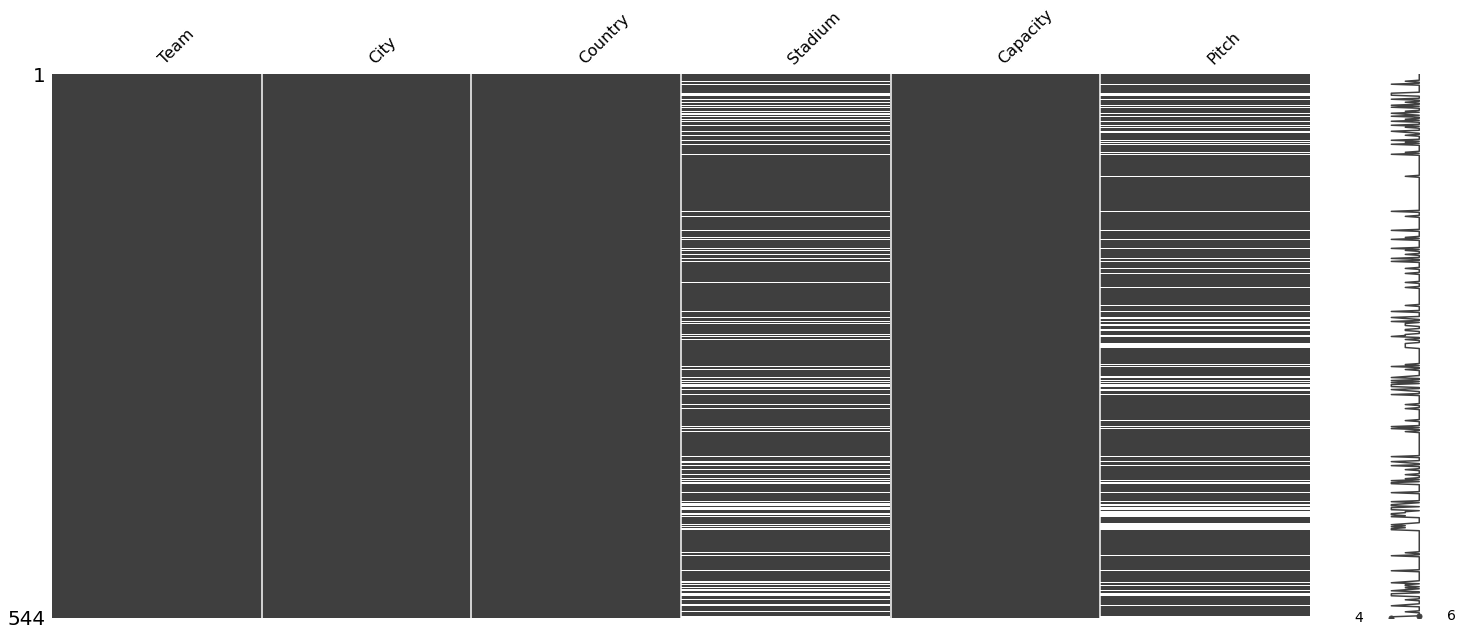

In [14]:
msn.matrix(team_info_df)

In [23]:
team_info_df.isnull().sum()/len(team_info_df)

Team        0.000000
City        0.000000
Country     0.000000
Stadium     0.178309
Capacity    0.000000
Pitch       0.178309
dtype: float64

In [34]:
team_info_cols_with_null = ['Stadium', 'Pitch']
for col in team_info_cols_with_null:
  team_info_df[col] = team_info_df[col].astype('category')
  print(team_info_df[col].value_counts())
  print(team_info_df[col].unique())
  print(team_info_df[team_info_df[col].isnull()])

Stadio Città del Tricolore                2
Stadio Marc'Antonio Bentegodi             2
Stadio Atleti Azzurri d'Italia            2
Cartagonova                               2
Cerro del Espino                          2
                                         ..
Stade Muncipal de Péronnas                1
Stade Municipal Ange Casanova Stiletto    1
Stade Océane                              1
Stade Parsemain                           1
A Malata                                  1
Name: Stadium, Length: 442, dtype: int64
['Lohrheidestadion', 'Olympiastadion Berlin', 'Sportpark Unterhaching', 'Südstadion', 'Schauinsland-Reisen-Arena', ..., 'Stadio Silvio Piola', 'Stadio Polisportivo Provinciale', 'Stadio Comunale Domenico Francioni', 'Stadio Comunale Chiavari', 'Stadio San Vito']
Length: 443
Categories (442, object): ['Lohrheidestadion', 'Olympiastadion Berlin', 'Sportpark Unterhaching',
                           'Südstadion', ..., 'Stadio Polisportivo Provinciale',
                     

# Match Info

In [35]:
match_info_df = pd.read_csv('https://raw.githubusercontent.com/PascalLiPooKim/Football-prediction-model-project/data-wrangling/Football_Data/Football_Data/Match_Info.csv')
match_info_df.head()

,Link,Date_New,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red
0,/match/saarbrucken/stuttgarter-kickers/1990,"Saturday, 29 July 1989, 15:00",\nReferee: Hans-Jürgen Weber\n,0.0,0.0,3.0,0.0
1,/match/sc-freiburg/unterhaching/1990,"Saturday, 29 July 1989, 15:00",\nReferee: Kurt Wittke\n,1.0,0.0,0.0,0.0
2,/match/vfl-osnabruck/meppen/1990,"Saturday, 29 July 1989, 15:00",\nReferee: Werner Föckler\n,3.0,0.0,2.0,0.0
3,/match/rot-weiss-essen/schalke-04/1990,"Saturday, 29 July 1989, 15:00",\nReferee: Heinz Werner\n,2.0,0.0,2.0,0.0
4,/match/alemannia-aachen/msv-duisburg/1990,"Saturday, 29 July 1989, 15:00",\nReferee: Hans-Peter Dellwing\n,1.0,0.0,1.0,0.0


In [36]:
match_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143348 entries, 0 to 143347
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Link         143348 non-null  object 
 1   Date_New     143348 non-null  object 
 2   Referee      143348 non-null  object 
 3   Home_Yellow  122798 non-null  float64
 4   Home_Red     122798 non-null  float64
 5   Away_Yellow  122798 non-null  float64
 6   Away_Red     122798 non-null  float64
dtypes: float64(4), object(3)
memory usage: 7.7+ MB


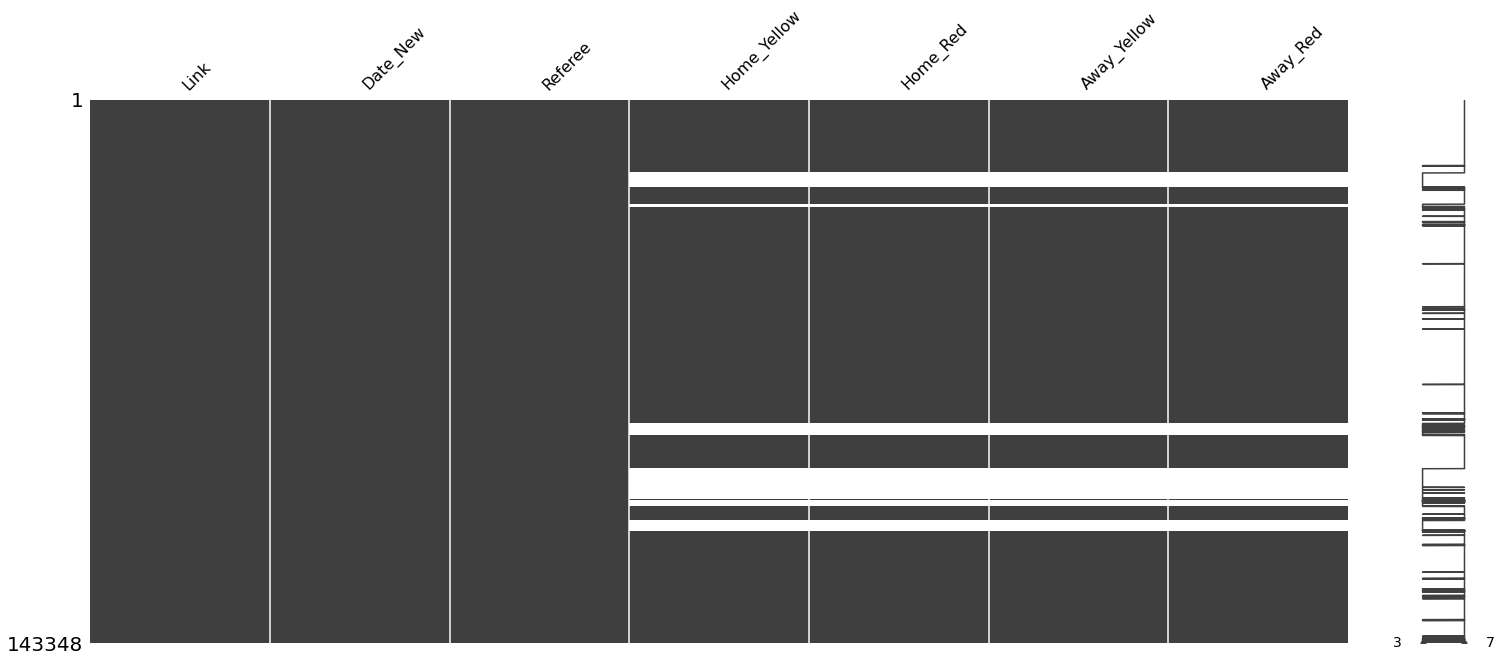

In [37]:
msn.matrix(match_info_df)

In [38]:
match_info_df.isnull().sum()/len(match_info_df)

Link           0.000000
Date_New       0.000000
Referee        0.000000
Home_Yellow    0.143357
Home_Red       0.143357
Away_Yellow    0.143357
Away_Red       0.143357
dtype: float64

In [41]:
match_info_df['Date_New	'] = pd.to_datetime(match_info_df['Date_New'])
match_info_df['Date_New	']

0        1989-07-29 15:00:00
1        1989-07-29 15:00:00
2        1989-07-29 15:00:00
3        1989-07-29 15:00:00
4        1989-07-29 15:00:00
                 ...        
143343   1998-09-19 00:00:00
143344   1994-05-17 00:00:00
143345   1999-01-08 00:00:00
143346   2021-02-27 19:00:00
143347   1998-12-05 00:00:00
Name: Date_New\t, Length: 143348, dtype: datetime64[ns]